<a href="https://colab.research.google.com/github/yewonlee5/yewonlee5.github.io/blob/main/Siamese%20Neural%20Networks%20(Thesis)/THESIS_MODEL2_Siamese_Contrastive_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imports

%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import pandas as pd
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as F2

In [ ]:
# help functions

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
# configurations

class Config():
    training_dir = "./drive/MyDrive/thesis/output/train/"
    validating_dir = "./drive/MyDrive/thesis/output/val/"
    testing_dir = "./drive/MyDrive/thesis/output/test/"
    train_batch_size = 64
    train_number_epochs = 100

In [ ]:
# Define WhitePad

class WhitePad:
  def __call__(self, image):
    max_wh = max(image.size)
    p_left, p_top = [(max_wh - s)//2 for s in image.size]
    p_right, p_bottom = [max_wh - (s + pad) for s, pad in zip(image.size, [p_left, p_top])]
    padding = (p_left, p_top, p_right, p_bottom)
    return F2.pad(image, padding, 255, 'constant')



In [ ]:
#It will read two images and return them, as well as their label. If they are in the same category, the same person, it will return 0, and otherwise, it will return 1.

# custom dataset class (Siamese - contrastive loss)

class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self,index):
        # img0_tuple = random.choice(self.imageFolderDataset.imgs)
        img0_tuple = self.imageFolderDataset.imgs[index]

        random_list = self.imageFolderDataset.imgs[:index] + self.imageFolderDataset.imgs[index+1:]

        #we need to make sure approx 50% of images are in the same class


        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(random_list)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found

                img1_tuple = random.choice(random_list)
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
# image folder dataset

folder_dataset = dset.ImageFolder(root=Config.training_dir)
folder_dataset_val = dset.ImageFolder(root=Config.validating_dir)

In [ ]:
# into siamese dataset with transform (white padding, resize, to tensor)

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([
                                                                      WhitePad(),
                                                                      transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


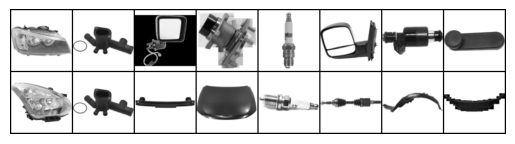

[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [ ]:
# visualizing samples

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
# Neural Net Definition (Standard CNN) # Contrastive Loss

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
# Contrastive Loss

class ContrastiveLoss(torch.nn.Module):


    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
# training

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:
# validating

val_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_val,
                                        transform=transforms.Compose([WhitePad(),
                                                                      transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

val_dataloader = DataLoader(val_dataset,num_workers=6,batch_size=1,shuffle=True)

In [ ]:
# ContrastiveLoss

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

# Resume training

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/thesis/model2_loss_accuracy_3.csv', index_col=0)

In [ ]:
train_losses = list(df['training_loss'])
val_losses = list(df['validation_loss'])
train_accuracy = list(df['training_accuracy'])
val_accuracy = list(df['validation_accuracy'])

In [ ]:
# load the model checkpoint
checkpoint = torch.load('/content/drive/MyDrive/thesis/checkpoint_Contrastive_70.pth')
# load model weights state_dict
net.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')
# load trained optimizer state_dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('Previously trained optimizer state_dict loaded...')
epochs = checkpoint['epoch']
# load the criterion
criterion = checkpoint['loss']
print('Trained model loss function loaded...')
print(f"Previously trained for {epochs} number of epochs...")
# train for more epochs
# epochs = new_epochs
# print(f"Train for {epochs} more epochs...")

Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Trained model loss function loaded...
Previously trained for 66 number of epochs...


In [ ]:
# Model 2 # Contrastive Loss # Training with Validation!!
train_losses = []
val_losses = []

train_accuracy = []
val_accuracy = []

# Execution time
import time

# get starting time
start = time.time()


for epoch in range(0,Config.train_number_epochs):
    running_loss = 0.0
    correct = 0.0
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        running_loss += loss_contrastive.item()
        # Calculate the accuracy for this batch
        res = F.pairwise_distance(output1,output2,keepdim=True)
        label = label[0].tolist()
        label = int(label[0])

        # Threshold
        result = torch.max(res,1)[0][0].item()
        if result <= 1.7:
          result = 0
        else:
          result = 1

        if label == result:
          correct += 1

        if i %10 == 0 :
          print("Epoch number {} Training loss {}".format(epoch+1, loss_contrastive.item()))

    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    avg_train_accuracy = correct / len(train_dataloader)
    train_accuracy.append(avg_train_accuracy)



    # check validation loss after every epoch
    val_running_loss = 0.0
    val_correct = 0.0

    with torch.no_grad():
      net.eval()
      for i, data in enumerate(val_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        val_running_loss += loss_contrastive.item()

        # Calculate the validating accuracy
        res = F.pairwise_distance(output1,output2,keepdim=True)
        label = label[0].tolist()
        label = int(label[0])

        # Threshold
        result = torch.max(res,1)[0][0].item()
        if result <= 1.7:
          result = 0
        else:
          result = 1

        if label == result:
          correct += 1


      avg_val_loss = val_running_loss / len(val_dataloader)
      val_losses.append(avg_val_loss)

      avg_val_accuracy = correct / len(val_dataloader)
      val_accuracy.append(avg_val_accuracy)

      elapsed_time = (time.time() - start)
      print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}, Accumulated Execution time: {:.2f}'.format(epoch+1, Config.train_number_epochs, avg_train_loss, avg_val_loss, elapsed_time))
      print('Epoch [{}/{}],Train Accuracy: {:.4f}, Valid Accuracy: {:.8f}'.format(epoch+1, Config.train_number_epochs, avg_train_accuracy, avg_val_accuracy))

      # For each epoch, save model checkpoint
      torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, '/content/drive/MyDrive/thesis/checkpoint_Contrastive_2ndtry_50.pth')
      # For each epoch, save loss & accuracy
      df = pd.DataFrame({'training_loss': train_losses, 'validation_loss': val_losses, 'training_accuracy': train_accuracy, 'validation_accuracy': val_accuracy} )
      df.to_csv('/content/drive/MyDrive/thesis/model2_loss_accuracy_2ndtry.csv')


elapsed_time = (time.time() - start)
print("Finished Training")
print(elapsed_time)

Epoch number 1 Training loss 1.494483470916748
Epoch number 1 Training loss 1.4644975662231445


In [ ]:
# save
torch.save(net.state_dict(), '/content/drive/MyDrive/thesis/checkpoint_Contrastive_100.pth')

In [ ]:
# load the state
# state_dict = torch.load('checkpoint.pth')

state_dict = torch.load(r"/content/drive/MyDrive/thesis/checkpoint_Contrastive_100.pth")
print(state_dict.keys())

odict_keys(['cnn1.1.weight', 'cnn1.1.bias', 'cnn1.3.weight', 'cnn1.3.bias', 'cnn1.3.running_mean', 'cnn1.3.running_var', 'cnn1.3.num_batches_tracked', 'cnn1.5.weight', 'cnn1.5.bias', 'cnn1.7.weight', 'cnn1.7.bias', 'cnn1.7.running_mean', 'cnn1.7.running_var', 'cnn1.7.num_batches_tracked', 'cnn1.9.weight', 'cnn1.9.bias', 'cnn1.11.weight', 'cnn1.11.bias', 'cnn1.11.running_mean', 'cnn1.11.running_var', 'cnn1.11.num_batches_tracked', 'fc1.0.weight', 'fc1.0.bias', 'fc1.2.weight', 'fc1.2.bias', 'fc1.4.weight', 'fc1.4.bias'])


In [ ]:
# load the state dict into the model
net.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# Model2
print("model: \n\n", net, '\n')
print("The state dict keys: \n\n", net.state_dict().keys())

model: 

 SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
) 

The state dict keys: 

 odict_keys(['cn

<ipython-input-5-14bc671f4fd9>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


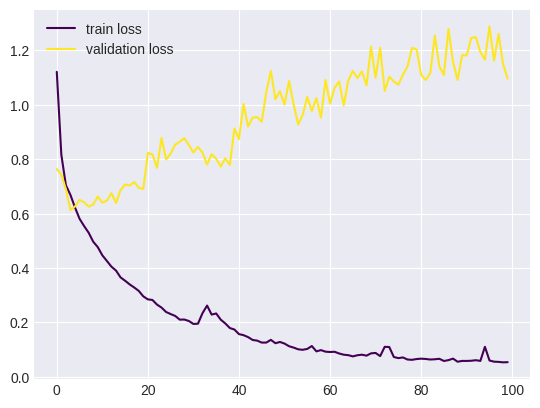

In [ ]:
# Model2 # Plot # 100 epochs

total_epochs = 100

x = [i for i in range(total_epochs)]

plt.style.use("seaborn-darkgrid")
plt.plot(x, train_losses, label = "train loss", color = '#440154')
plt.plot(x, val_losses, label = "validation loss", color = '#fde725')
plt.viridis()
plt.legend()
plt.show()

<ipython-input-6-6cc8f9632da5>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


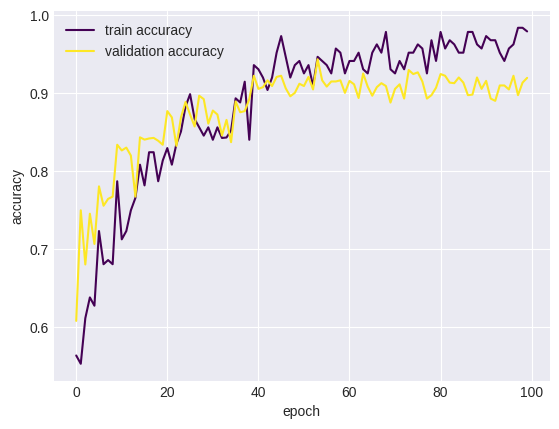

In [ ]:
# Accuracy History _ 100


x = [i for i in range(total_epochs)]

plt.style.use("seaborn-darkgrid")
plt.plot(x, train_accuracy, label = "train accuracy", color = '#440154')
plt.plot(x, val_accuracy, label = "validation accuracy", color = '#fde725')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.viridis()
plt.legend()
plt.show()

Test

In [ ]:
# test dataset

folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
test_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([WhitePad(),
                                                                      transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

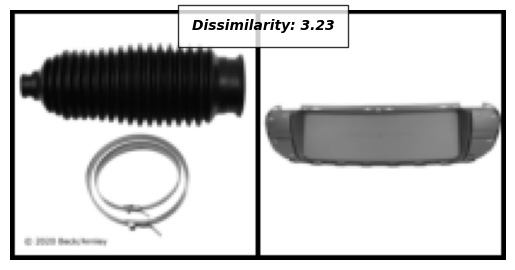

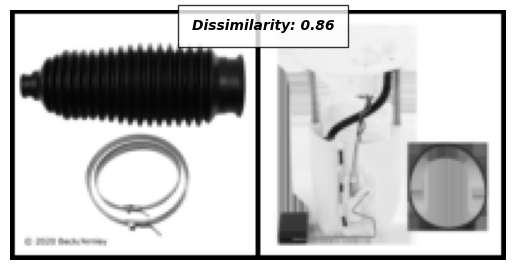

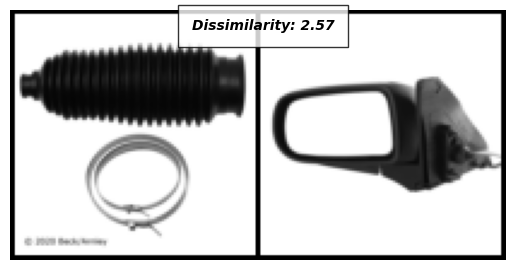

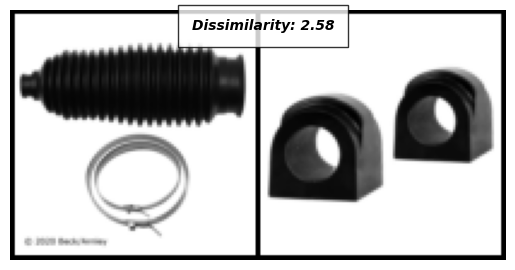

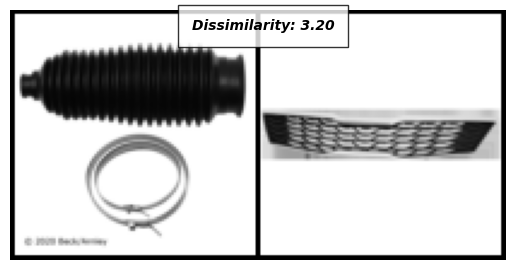

In [ ]:
# Simple Testing


dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(5):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)

    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

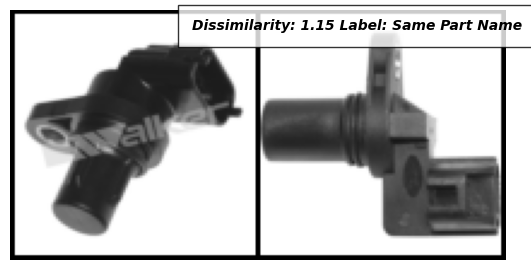

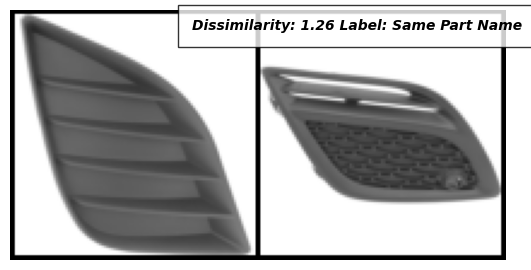

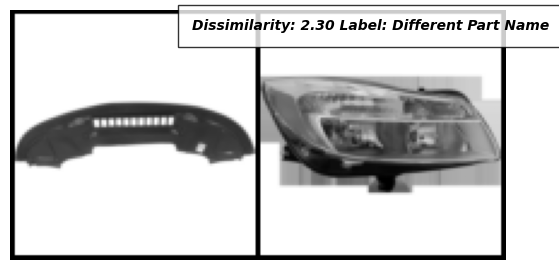

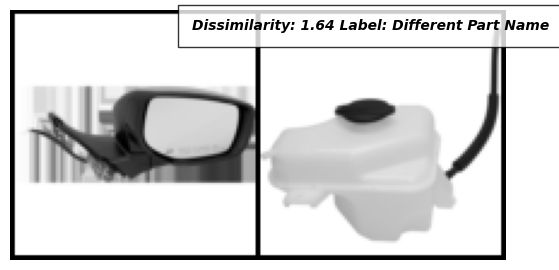

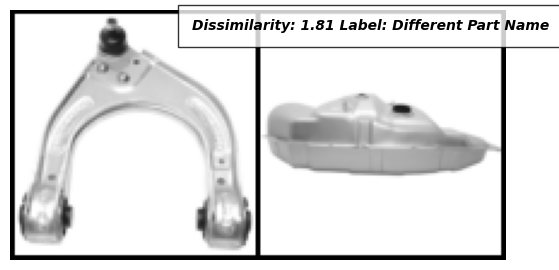

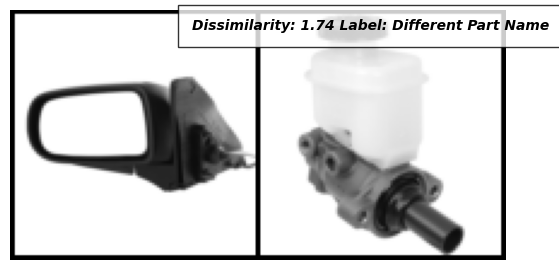

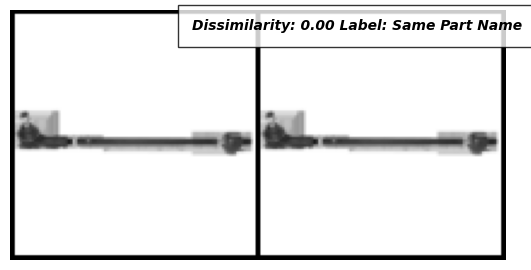

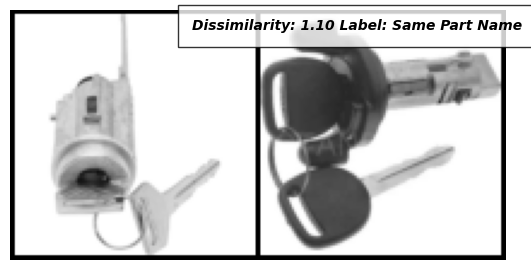

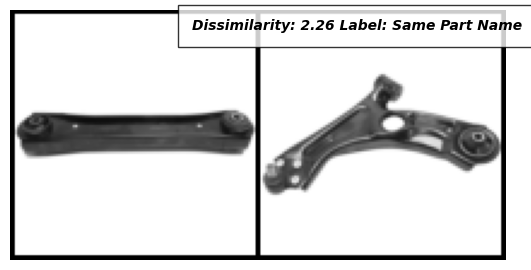

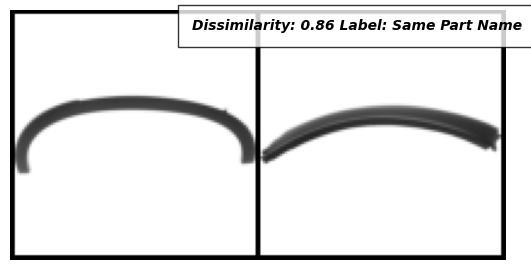

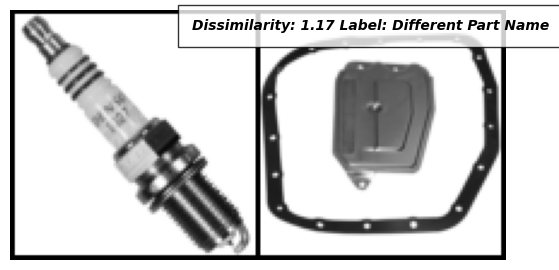

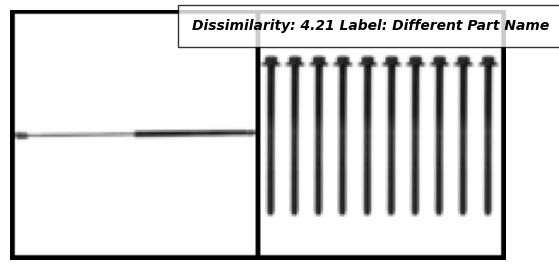

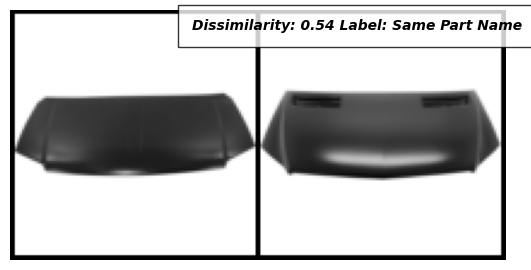

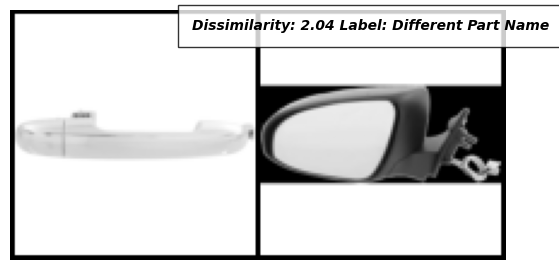

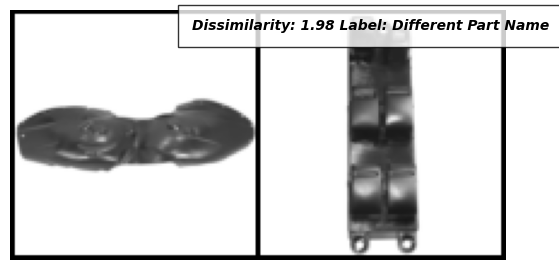

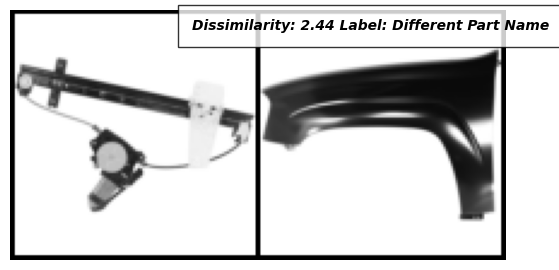

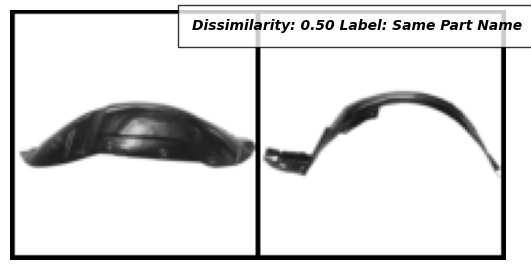

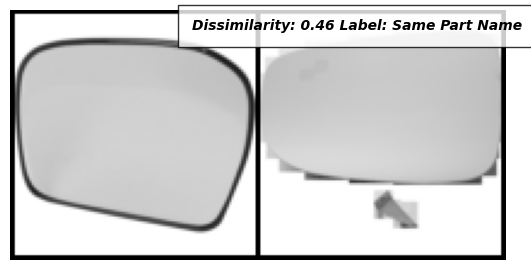

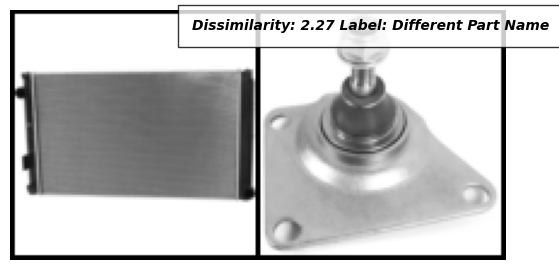

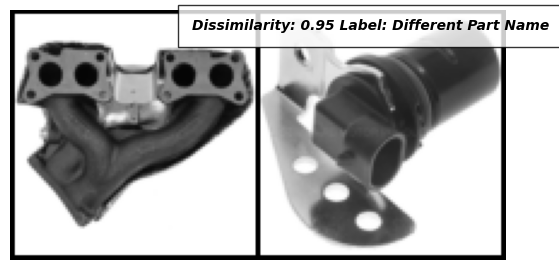

In [ ]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]]) # 0 (same part name)
list_1 = torch.FloatTensor([[1]]) # 1 (different part name)
for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data #(#random1, #random2, if they are from the same part name)
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = net(x0.cuda(),x1.cuda())
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Same Part Name"
  else:
    label="Different Part Name"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

# Threshold for the test metrics

In [ ]:
# train dataset with batch size = 1
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=1)

In [ ]:
# Distribution of Euclidean distance

from tqdm import tqdm

distances = []
labels = []


for i, data in tqdm(enumerate(train_dataloader,0)):
    img0, img1 , label = data
    img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
    output1,output2 = net(img0,img1)
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

    distances.append(euclidean_distance)
    labels.append(label)


In [ ]:
len(distances)

9254

In [ ]:
len(labels)

9254

In [ ]:
distances_l = []
labels_l = []

for i in distances:
  distances_l.append(i.item())

for i in labels:
  labels_l.append(i.item())

In [ ]:
set_cutoff = pd.DataFrame(
    {'distance': distances_l,
     'label': labels_l
    })


In [ ]:
set_cutoff.to_csv('/content/drive/MyDrive/thesis/Contrastive_threshold.csv')

In [ ]:
set_cutoff = pd.read_csv('/content/drive/MyDrive/thesis/Contrastive_threshold.csv')
set_cutoff

,Unnamed: 0,distance,label
0,0,1.551691,0.0
1,1,1.036089,0.0
2,2,1.286148,0.0
3,3,1.108197,0.0
4,4,0.369239,1.0
...,...,...,...
9249,9249,1.529068,0.0
9250,9250,2.172640,0.0
9251,9251,4.375481,1.0
9252,9252,0.558190,0.0


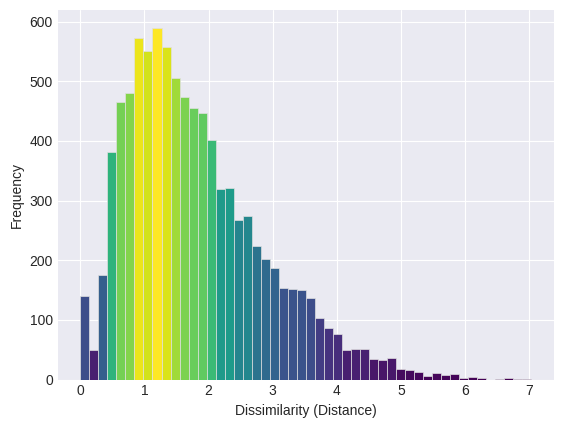

In [ ]:
# plt.hist(set_cutoff['distance'],color= '#21918c',edgecolor = "#fde725")

n, bins, patches = plt.hist(set_cutoff['distance'], bins=50, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5)

n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))


plt.style.use("seaborn-v0_8-darkgrid")

plt.xlabel('Dissimilarity (Distance)')
plt.ylabel('Frequency')
# plt.title("Histogram of Dissimilarity (Distance)")
plt.show()

In [ ]:
def siamese_metrics(cutoff):
  accuracy=0
  precision=0
  recall=0
  f1=0

  TP=0
  FP=0 # For example, this means that patients who were predicted to have cancer were actually health.
  TN=0
  FN=0

  for i in range(set_cutoff.shape[0]):
    distance, label = set_cutoff.loc[i, "distance"], set_cutoff.loc[i, "label"]
    if (distance < cutoff) & (label == 0) :
      TP += 1
    elif (distance < cutoff) & (label == 1) :
      FP += 1
    elif (distance >= cutoff) & (label == 1) :
      TN += 1
    else :
      FN += 1

  accuracy=((TP+TN)/(TP+FP+TN+FN))
  precision=(TP/(TP+FP))
  recall=(TP/(TP+FN))
  f1 = 2*precision*recall / (precision+recall)

  return accuracy, precision, recall, f1


In [ ]:
# graph metrics of by cutoff


bins = np.arange (0.1, 7, 0.1).tolist()
cutoff_accuracy = []
cutoff_precision = []
cutoff_recall = []
cutoff_f1 = []

for i in bins:
  accuracy = siamese_metrics(i)[0]
  precision = siamese_metrics(i)[1]
  recall = siamese_metrics(i)[2]
  f1 = siamese_metrics(i)[3]
  cutoff_accuracy.append(accuracy)
  cutoff_precision.append(precision)
  cutoff_recall.append(recall)
  cutoff_f1.append(f1)

<ipython-input-8-e7e0c59f7712>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


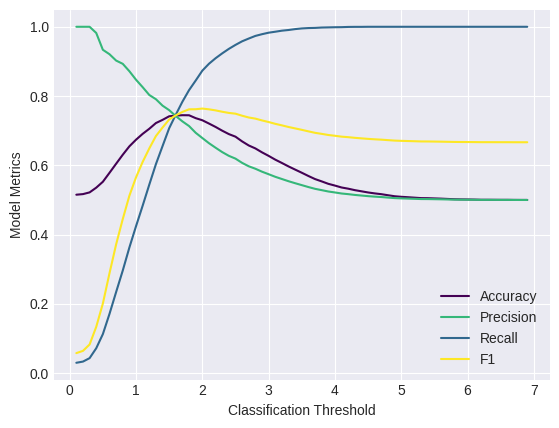

In [ ]:

plt.style.use("seaborn-darkgrid")

plt.plot(bins, cutoff_accuracy, label = "Accuracy", color = '#440154')
plt.plot(bins, cutoff_precision, label = "Precision", color = '#35b779')
plt.plot(bins, cutoff_recall, label = "Recall", color = '#31688e')
plt.plot(bins, cutoff_f1, label = "F1", color = '#fde725')

plt.xlabel('Classification Threshold')
plt.ylabel('Model Metrics')
# plt.title("Model Metrics by Threshold of Dissimilarity (distance)")
plt.legend()
plt.show()


In [ ]:
max(cutoff_accuracy)

0.7446509617462719

In [ ]:
bins[cutoff_accuracy.index(max(cutoff_accuracy))]

1.7000000000000002

In [ ]:
# Accuracy Check with test dataset

accuracy=0
counter=0
correct=0
for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data
  # onehsot applies in the output of 128 dense vectors which is then converted to 2 dense vectors
  output1,output2 = net(x0.cuda(),x1.cuda())
  res=torch.abs(output1 - output2)
  label=label[0].tolist() # tensor into list (0 or 1)
  label=int(label[0]) # list into integer (0 or 1)

  result=torch.max(res,1)[0][0].item()
  if result <= 0.5:
    result = 0
  else:
    result = 1

  if label == result:
    correct=correct+1
  counter=counter+1
#   if counter ==20:
#      break

accuracy=(correct/len(test_dataloader))*100
print("Accuracy:{}%".format(accuracy))

Accuracy:71.12092766427388%


In [ ]:
# THRESHOLD = 0.5

# Precision Score = TP / (FP + TP) : specificity
# Recall Score = TP / (FN + TP) : sensitivity
# F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)

accuracy=0
precision=0
recall=0
f1=0

TP=0
FP=0
TN=0
FN=0

for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data
  # onehsot applies in the output of 128 dense vectors which is then converted to 2 dense vectors
  output1,output2 = net(x0.cuda(),x1.cuda())

  # res=torch.abs(output1 - output2)
  res = F.pairwise_distance(output1, output2, keepdim = True)


  label=label[0].tolist() # tensor into list (0 or 1)
  label=int(label[0]) # list into integer (0 or 1)


  # THRESHOLD
  result=torch.max(res,1)[0][0].item()
  if result <= 0.5:
    result = 0 # similar # Positive
  else:
    result = 1 # dissimilar # Negative


  if label == result and result == 0:
    TP+=1
  elif label != result and result == 0:
    FP+=1
  elif label == result and result == 1:
    TN+=1
  else:
    FN+=1
#   if counter ==20:
#      break

accuracy=((TP+TN)/(TP+FP+TN+FN))*100
print("Accuracy:{}%".format(accuracy))

precision=(TP/(TP+FP))*100
print("Precision:{}%".format(precision))

recall=(TP/(TP+FN))*100
print("Recall:{}%".format(recall))

f1 = 2*precision*recall / (precision+recall)
print("F1 Score:{}%".format(f1))


Accuracy:62.06515737161789%
Precision:95.65217391304348%
Recall:26.361655773420477%
F1 Score:41.33219470538001%


In [ ]:
print(TP)
print(TN)
print(FP)
print(FN)

242
882
11
676


In [ ]:
# THRESHOLD = 1.7 # BEST!!!

# Precision Score = TP / (FP + TP) : specificity
# Recall Score = TP / (FN + TP) : sensitivity
# F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)

accuracy=0
precision=0
recall=0
f1=0

TP=0
FP=0
TN=0
FN=0

for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data
  # onehsot applies in the output of 128 dense vectors which is then converted to 2 dense vectors
  output1,output2 = net(x0.cuda(),x1.cuda())
  res = F.pairwise_distance(output1, output2, keepdim = True)
  label=label[0].tolist() # tensor into list (0 or 1)
  label=int(label[0]) # list into integer (0 or 1)


  # THRESHOLD
  result=torch.max(res,1)[0][0].item()
  if result <= 1.7:
    result = 0 # similar # Positive
  else:
    result = 1 # dissimilar # Negative


  if label == result and result == 0:
    TP+=1
  elif label != result and result == 0:
    FP+=1
  elif label == result and result == 1:
    TN+=1
  else:
    FN+=1
#   if counter ==20:
#      break

accuracy=((TP+TN)/(TP+FP+TN+FN))*100
print("Accuracy:{}%".format(accuracy))

precision=(TP/(TP+FP))*100
print("Precision:{}%".format(precision))

recall=(TP/(TP+FN))*100
print("Recall:{}%".format(recall))

f1 = 2*precision*recall / (precision+recall)
print("F1 Score:{}%".format(f1))


print("True Positive: {}".format(TP))
print("True Negative: {}".format(TN))
print("False Positive: {}".format(FP))
print("False Negative: {}".format(FN))

Accuracy:70.23743787962452%
Precision:68.60236220472441%
Recall:76.00872410032716%
F1 Score:72.11588204862908%
True Positive: 697
True Negative: 575
False Positive: 319
False Negative: 220


In [ ]:
# THRESHOLD = 3

# Precision Score = TP / (FP + TP) : specificity
# Recall Score = TP / (FN + TP) : sensitivity
# F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)

accuracy=0
precision=0
recall=0
f1=0

TP=0
FP=0
TN=0
FN=0

for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data
  # onehsot applies in the output of 128 dense vectors which is then converted to 2 dense vectors
  output1,output2 = net(x0.cuda(),x1.cuda())
  res = F.pairwise_distance(output1, output2, keepdim = True)
  label=label[0].tolist() # tensor into list (0 or 1)
  label=int(label[0]) # list into integer (0 or 1)


  # THRESHOLD
  result=torch.max(res,1)[0][0].item()
  if result <= 3:
    result = 0 # similar # Positive
  else:
    result = 1 # dissimilar # Negative


  if label == result and result == 0:
    TP+=1
  elif label != result and result == 0:
    FP+=1
  elif label == result and result == 1:
    TN+=1
  else:
    FN+=1
#   if counter ==20:
#      break

accuracy=((TP+TN)/(TP+FP+TN+FN))*100
print("Accuracy:{}%".format(accuracy))

precision=(TP/(TP+FP))*100
print("Precision:{}%".format(precision))

recall=(TP/(TP+FN))*100
print("Recall:{}%".format(recall))

f1 = 2*precision*recall / (precision+recall)
print("F1 Score:{}%".format(f1))


print("True Positive: {}".format(TP))
print("True Negative: {}".format(TN))
print("False Positive: {}".format(FP))
print("False Negative: {}".format(FN))

Accuracy:56.929872998343455%
Precision:53.241895261845386%
Recall:96.60633484162896%
F1 Score:68.64951768488746%
True Positive: 854
True Negative: 177
False Positive: 750
False Negative: 30
